In [1]:
from torch import nn
import torch.nn.functional as F
from utils import MetricsCB, DeviceCB, ProgressCB, SingleBatchCB, set_seed, append_stats, conv
from datasets import load_dataset
from torcheval.metrics import MulticlassAccuracy
from dataloaders import DataLoaders
from learners import TrainLearner
from hooks import ActivationStats
from transforms import transformi
import fastcore.all as fc
from activations import init_weights
from functools import partial
from activations import GeneralReLU
from torch import optim

import torchvision.transforms.functional as TF,torch.nn.functional as F
from utils import inplace
from resnet import act_gr, ResBlock

from hooks import Hooks

set_seed(1)

/Users/dimitarruskov/miniconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/dimitarruskov/miniconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/dimitarruskov/miniconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <DB251723-D0A7-3D18-91AD-79131BDBDDBC> /Users/dimitarruskov/miniconda3/lib/python3.11/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024
def_device='cpu'
xmean,xstd = 0.28, 0.35
num_workers = 1 # set to 1 for debugging, otherwise - 4

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs) # add num_workers=4 when not debugging

iw = partial(init_weights, leaky=0.1)

# Non-ResNet Training cicle


In [5]:
def get_model(act=nn.ReLU, norm=nn.BatchNorm2d, nfs=None, nout=10):
    if nfs is None: nfs = [8, 16, 32, 64, 128]
    layers = []
    layers.append(conv(1, 8, stride=1, act=act, norm=norm))
    layers += [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    layers.append(conv(nfs[-1], nout, act=None, norm=norm, bias=True))
    layers.append(nn.Flatten())

    return nn.Sequential(*layers).to(def_device)

def fit(model, epochs=1, xtra_cbs=[]):
    cbs = [DeviceCB(), MetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(plot=True)]
    learn = TrainLearner(model, dls, loss_func=F.cross_entropy, lr=6e-2, cbs=cbs+list(xtra_cbs), opt_func=optim.AdamW)
    learn.fit(epochs)

astats = ActivationStats(append_stats, mod_filter=fc.risinstance(nn.Conv2d))

model = get_model(act=act_gr).apply(iw)
fit(model, xtra_cbs=[astats], epochs=5)

# Kaiming Normal + GeneralReLU

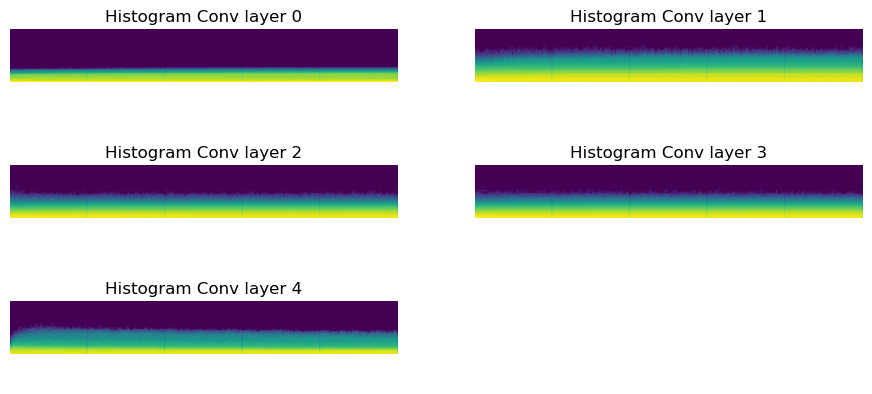

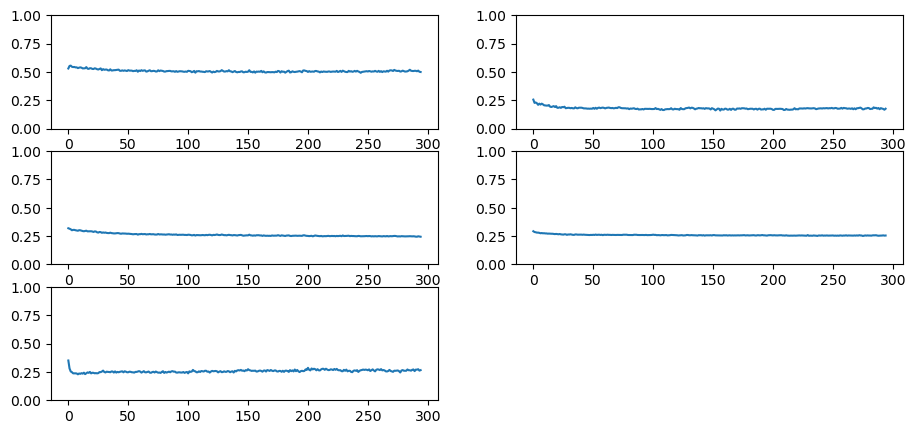

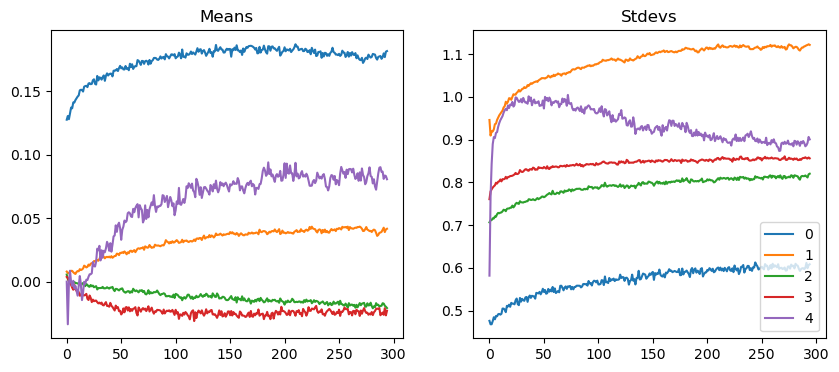

In [4]:
astats.color_dim()
astats.dead_chart()
astats.plot_stats()

# Kaiming Normal

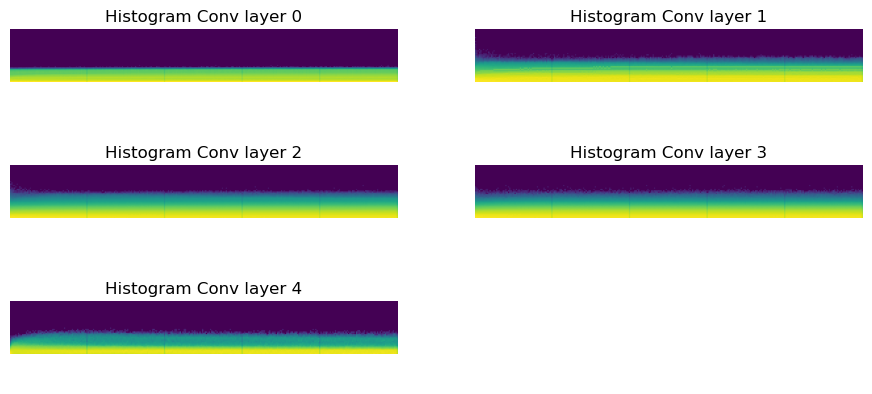

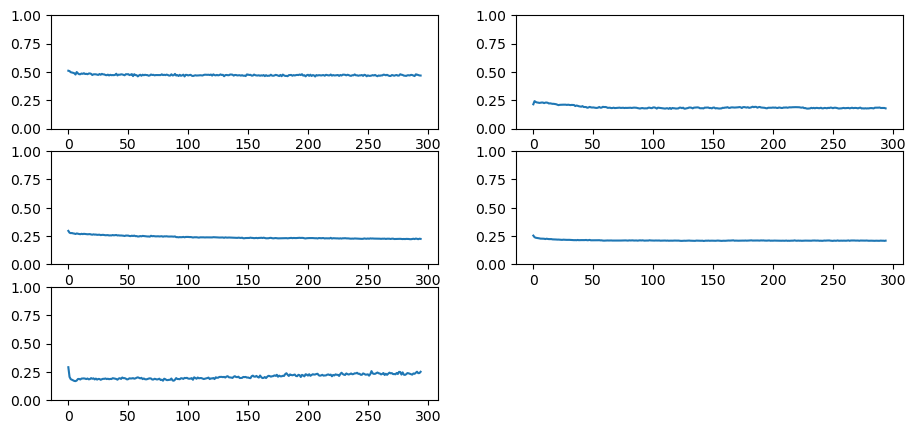

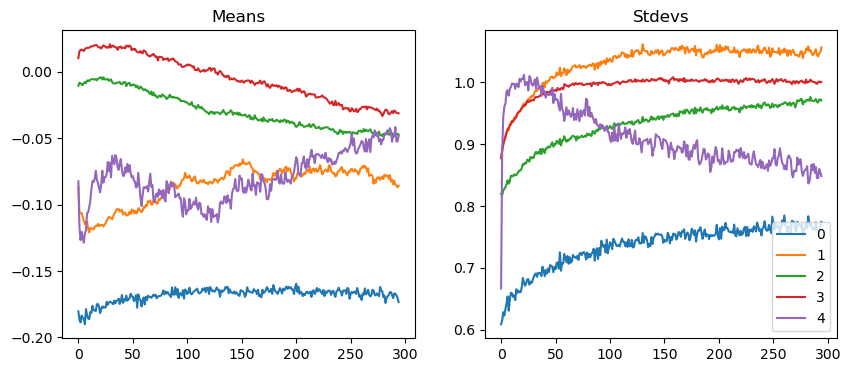

In [7]:
astats.color_dim()
astats.dead_chart()
astats.plot_stats()

# General ReLU

The first layer dead neurons are dropping by 25%
Overall performance for 5 epochs is worse than ReLU

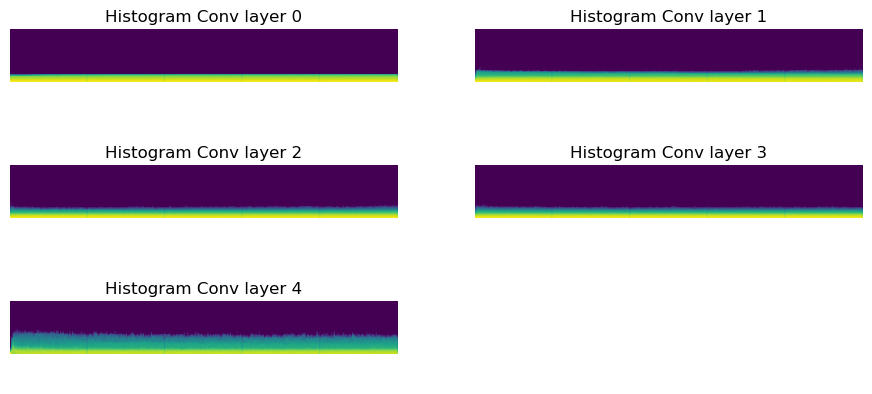

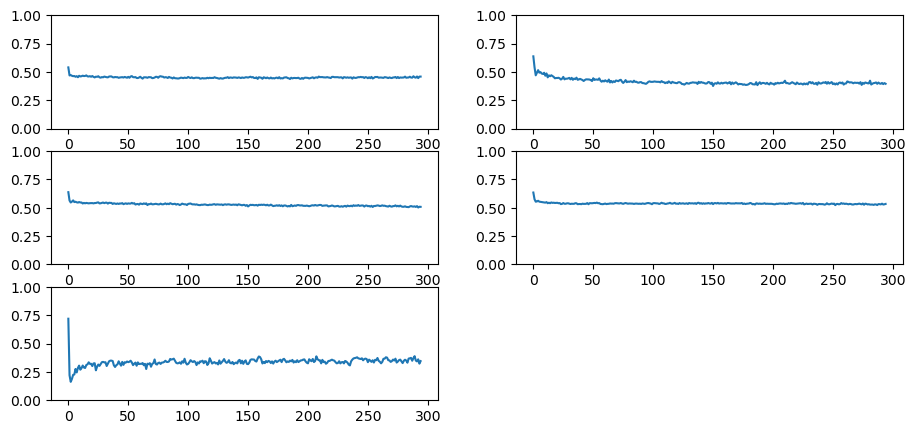

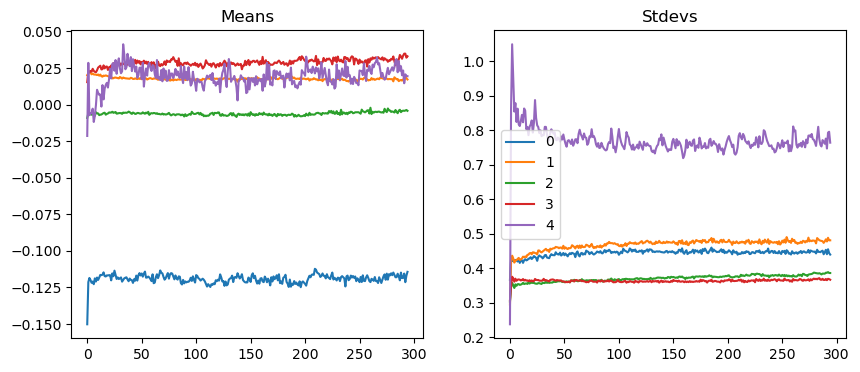

In [6]:
astats.color_dim()
astats.dead_chart()
astats.plot_stats()

# Swish LU

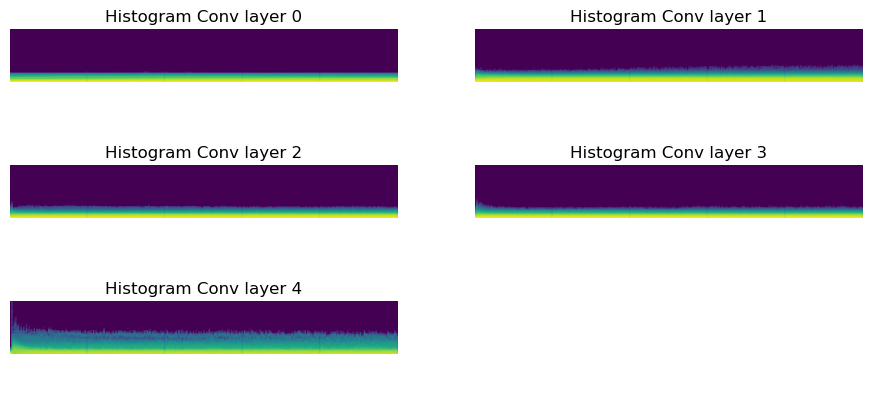

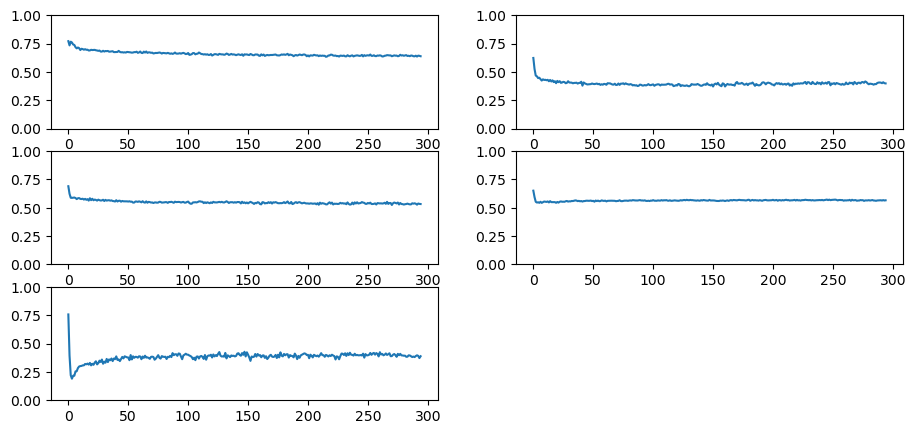

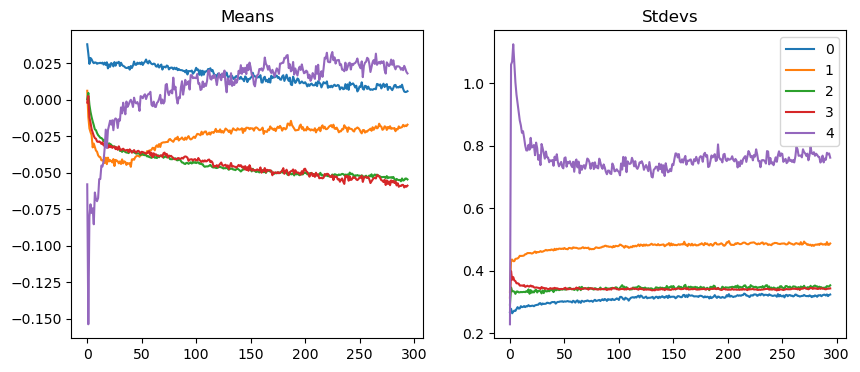

In [10]:
astats.color_dim()
astats.dead_chart()
astats.plot_stats()

# Random Relu

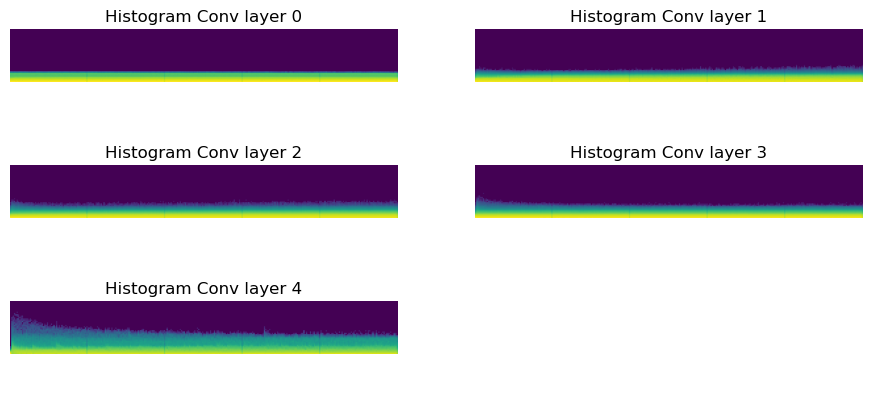

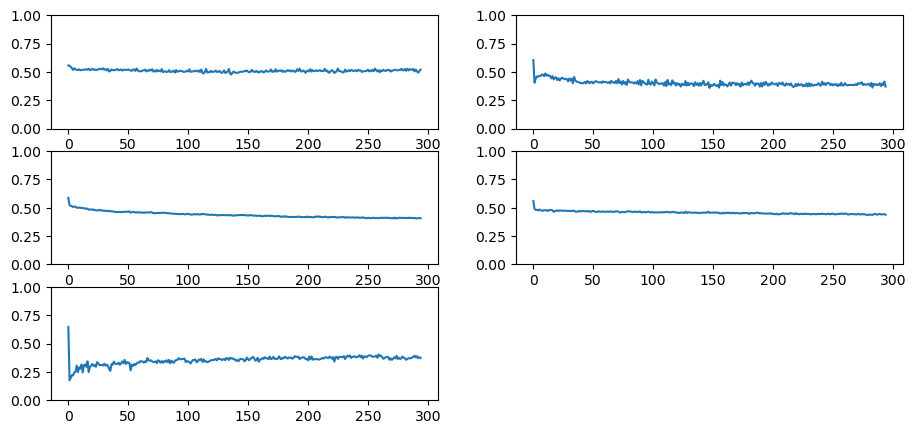

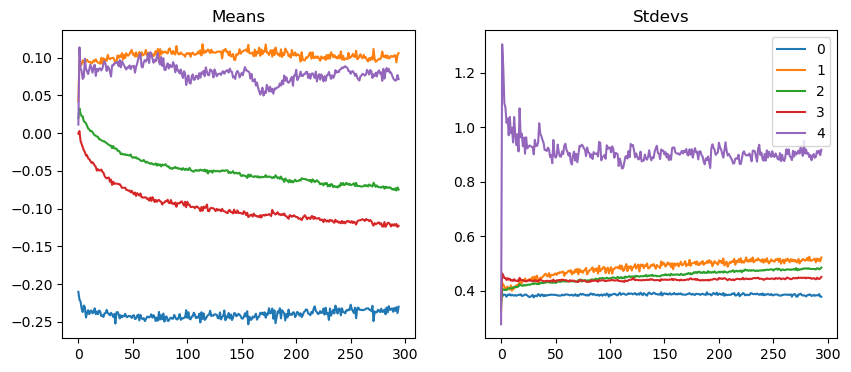

In [8]:
astats.color_dim()
astats.dead_chart()
astats.plot_stats()

# Leaky Relu

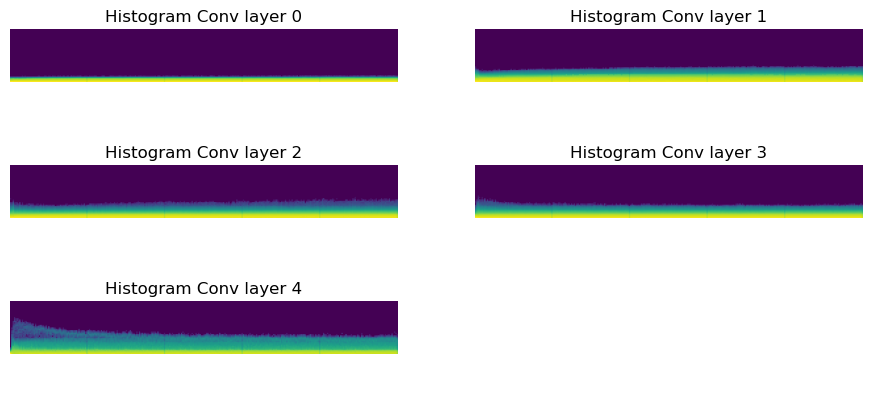

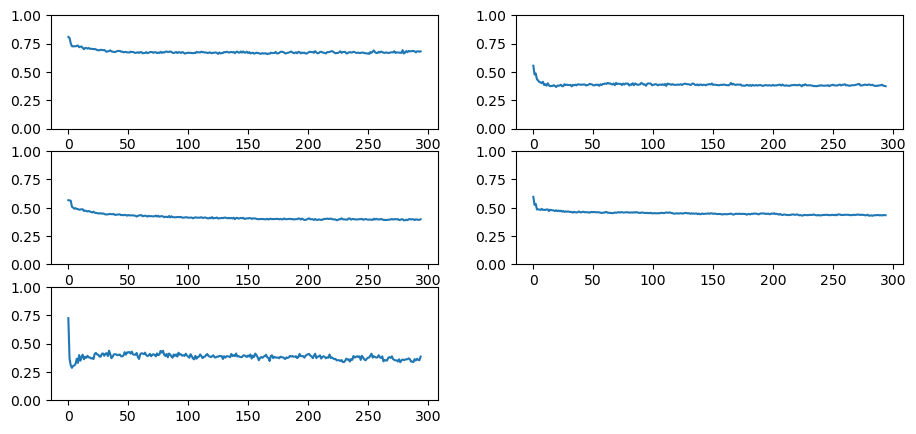

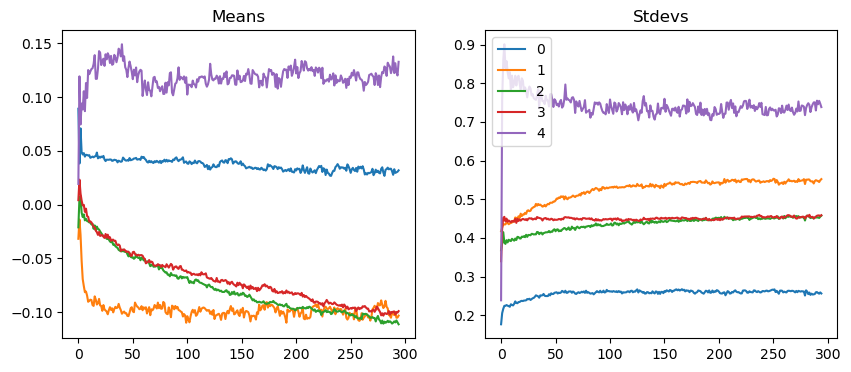

In [6]:
astats.color_dim()
astats.dead_chart()
astats.plot_stats()

# Batch Norm

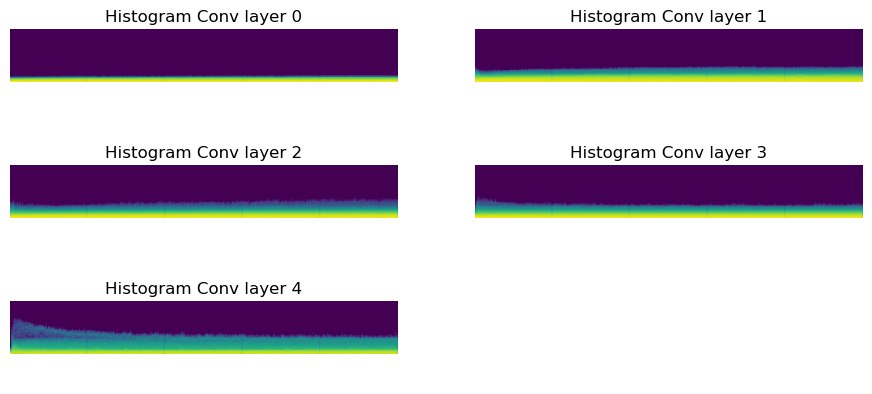

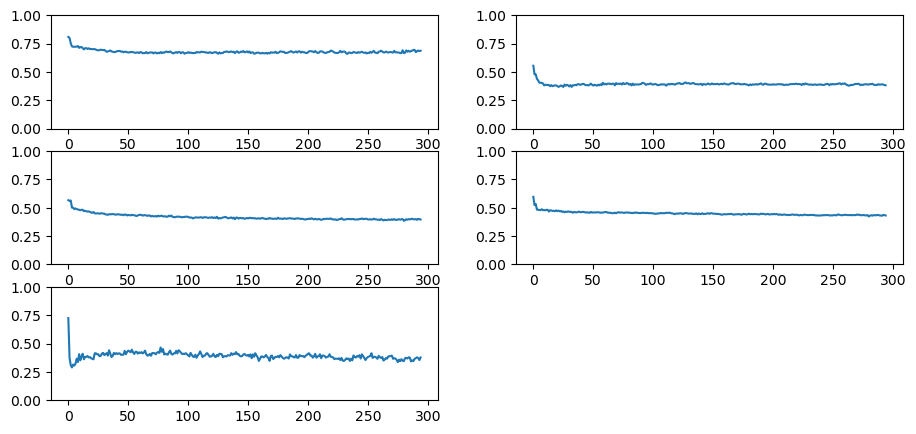

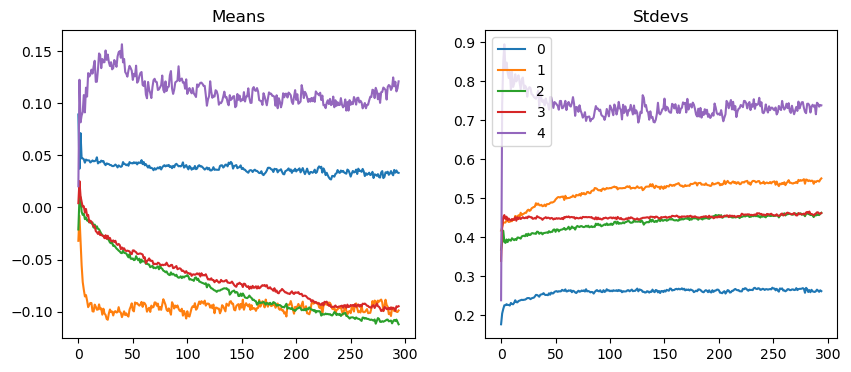

In [3]:
astats.color_dim()
astats.dead_chart()
astats.plot_stats()

# RESNET training cycle

Previous score with [1, 8, 16, 32, 64, 128] /w 5 epochs -> 0.884	0.328	4	eval

In [9]:
def get_model(act=nn.ReLU, nfs=(8, 16, 32, 64, 128, 256), norm=nn.BatchNorm2d, nout=10):
    layers = [ResBlock(1, 8, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], stride=2, act=act, norm=norm) for i in range(len(nfs)-1)]
    layers.append(nn.Flatten())
    layers.append(nn.Linear(nfs[-1], nout, bias=False))
    layers.append(nn.BatchNorm1d(10))

    return nn.Sequential(*layers).to(def_device)

def _print_shape(hook, mod, inp, outp): print(type(mod).__name__, inp[0].shape, outp.shape)

model = get_model()

learn = TrainLearner(model, dls, F.cross_entropy, cbs=[SingleBatchCB])
with Hooks(model, _print_shape) as hooks: learn.fit(1, train=False)

ResBlock torch.Size([2048, 1, 28, 28]) torch.Size([2048, 8, 28, 28])
ResBlock torch.Size([2048, 8, 28, 28]) torch.Size([2048, 16, 14, 14])
ResBlock torch.Size([2048, 16, 14, 14]) torch.Size([2048, 32, 7, 7])
ResBlock torch.Size([2048, 32, 7, 7]) torch.Size([2048, 64, 4, 4])
ResBlock torch.Size([2048, 64, 4, 4]) torch.Size([2048, 128, 2, 2])
ResBlock torch.Size([2048, 128, 2, 2]) torch.Size([2048, 256, 1, 1])
Flatten torch.Size([2048, 256, 1, 1]) torch.Size([2048, 256])
Linear torch.Size([2048, 256]) torch.Size([2048, 10])
BatchNorm1d torch.Size([2048, 10]) torch.Size([2048, 10])
after batch


TypeError: SingleBatchCB.after_batch() missing 1 required positional argument: 'learn'